# Part 2

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
import urllib
from urllib.request import urlopen
%matplotlib inline
import urllib.request
import datetime as dt
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
def generate_data(m,n,winnow=False):
    if winnow:
        data = np.random.randint(2, size=(m,(n+1)))
        data = np.sign(data)
    else:
        data = np.random.uniform(low=-1, high=1, size=(m,(n+1)))
        data = np.sign(data)
    x = data
    y = data[:,0]
    return x,y

def generate_data_winnow(m,n):
    data = np.random.randint(2, size=(m,(n+1)))
    data = np.sign(data)
    return data

def add_bias(x):
    x_with_bias = np.ones((x.shape[0],x.shape[1]+1))
    x_with_bias[:,:-1] = x
    return x_with_bias

## Binary Perceptron

In [3]:
# Binary perceptron algorithm 
# Learning rate? 
# Perceptron converges after making (R/eta)**2 mistakes/upates
def perceptron_train(x,y,max_epoch=20, tol=0.01, learning_rate=1,random_select=False,eta=0.001):
    m_train = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    x = add_bias(x)
    error_per_epoch = np.zeros(max_epoch)
    errors = np.zeros(m_train)
    W = np.zeros(n+1)
    R = np.sqrt(n+1) #max norm
    error_bound = (R/eta)**2 #maximum number of mistakes it makes before convergence. 
    num_errors = 0 
    
    if random_select:
        max_epoch =1
        m = np.random.randint(low=0, high=m_train) #select random number of times to train the perceptron. 
    else:
        m = m_train
        
    for epoch in range(max_epoch):
        #print('epoch=',epoch)
        errors = np.zeros(m)
        num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
    
        #iterate through training set
        for t in range(m):
            x_t = x[t,:]
            y_t = y[t]
            #pred_t = np.sign(W@x_t) #0 to begin with 
            pred_t = W @ x_t 
            
            #if pred_t*y_t<=0: 
            if pred_t* y_t < eta:
                #print('t=',t)
                #print('error! y_lab=', y_t)
                num_errors +=1
                W = W + learning_rate*x_t.T*y_t
                errors[t] = num_errors 
                if num_errors>= error_bound:
                    break
                
        error_per_epoch[epoch] = num_errors
        #print(epoch, 'error=',errors[-1])
        
        #print('current_error_rate', error_per_epoch)
        
        if epoch>1:
            #print('old_error=',error_per_epoch[epoch-1])
            #print('new_error=',error_per_epoch[epoch])
            diff_rates = (error_per_epoch[epoch-1] - error_per_epoch[epoch])/m
 
            #Stop if the error rate has increased, 
            #or the difference in error rate between the previous one and the current one < tolerance. 
            if error_per_epoch[epoch]/m < 0.05:
                print('error rate< 10%')
                if diff_rates<tol:
                    print('converging')
                    break
                elif diff_rates<0:
                    print('error increased')
                    break
                elif error_per_epoch[epoch]==0:
                    print('no error')
                    break
        
    return W, error_per_epoch[:epoch+1]


def perceptron_test(x_test,y_test,W):
    x_test = add_bias(x_test)
    m_test = x_test.shape[0]
    pred = np.sign(x_test@W) #(n,1) x (m_test,n)
    diff = pred - y_test
    mistakes = len(diff[diff!=0])   
    return mistakes,pred

In [4]:
x,y = generate_data(20,30)
W, error_per_epoch = perceptron_train(x,y,max_epoch=30, tol=0.01, learning_rate=1)

error rate< 10%
no error


In [5]:
mistakes,pred = perceptron_test(x[:10],y[:10],W)

In [6]:
error_per_epoch
### Does not seem to converge for some combination of x and y. 

array([8., 3., 2., 0.])

## Winnow

In [21]:
def winnow_train(x,y,max_epoch=20,tol=0.01, learning_rate=1):
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    error_per_epoch = np.zeros(max_epoch)
    errors = np.zeros(m)
    W = np.ones(n+1)
    x = add_bias(x)
    gamma_bound = n/2
    mistake_bound = (n/gamma_bound)**2
    num_errors = 0 
    
    #for epoch in range(max_epoch):
    epoch = 0
    while epoch < max_epoch:   
        errors = np.zeros(m)
        num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
        #iterate through training set
        for t in range(m):
            x_t = x[t,:]
            y_t = y[t]
            gamma = W@x_t
            
            if gamma>= gamma_bound:
                pred_t = 1
            else:
                pred_t = 0
            
            if pred_t != y_t:
                num_errors+=1
                power = (y_t - pred_t)*x_t/1.0 #1 when error made on positive class, -1 when error made on negative class
                W = W*(2**power) #element wise multiplication, and element wise power
                #Once weight>n, it should no longer change. 
                W[W>n] = n
                errors[t] = num_errors
                
        error_per_epoch[epoch] = num_errors
        
        if epoch>1:
            diff_rates = (error_per_epoch[epoch-1] - error_per_epoch[epoch])/m
            #print("Error rate is now ", error_per_epoch[epoch]/m )
            #Stop if the error rate has increased, 
            #or the difference in error rate between the previous one and the current one < tolerance. 
            if error_per_epoch[epoch]/m < 0.05:
                #print('error rate< 5%')
                if diff_rates<tol:
                    print('converging')
                    break
                elif diff_rates<0:
                    print('error increased')
                    break
                elif error_per_epoch[epoch]==0:
                    print('no error')  
                    break
        epoch += 1
    return W, error_per_epoch[:epoch+1]


def winnow_test(x_test,y_test,W):
    x_test = add_bias(x_test)
    m_test = x_test.shape[0]
    n = x_test.shape[1]
    gamma = x_test@W
    pred = np.zeros(m_test)
    pred[gamma>=n/2] = 1
    diff = pred - y_test
    #print(diff)
    mistakes = len(diff[diff!=0])  
    return mistakes,pred

In [22]:
x,y = generate_data(40,20,winnow=True)
W, error_per_epoch = winnow_train(x,y,max_epoch=15,tol=0.01, learning_rate=1)
mistakes,pred = winnow_test(x[:20],y[:20],W)
mistakes

converging


0

## Least Squares Regression

In [6]:
def compute_primal(X, Y):
    """
    Computes vector omega, which is called the primal form of the linear regression.
    :param X: the feature map vector
    :param Y: the target values of the data points
    :return: the vector omega
    """
    omega = np.linalg.pinv(X.T @ X) @ X.T @ Y
    return omega

def linear_predict(X_test, y_test, omega):
    f = X_test @ omega
    pred = np.where(f < 0, -1, 1)
    diff = pred - y_test
    mistakes = len(diff[diff!=0])
    return mistakes, pred

x,y = generate_data(40,20)
W = compute_primal(x,y)
mistakes,pred = linear_predict(x[:10], y[:10], W)
mistakes

0

## 1 Nearest Neighbors

In [7]:
def pairwise_distance_double(X1,X2): # distances of X training data, double matrices, X1 and X2
    X1_pow = (X1**2).sum(axis=1).reshape(X1.shape[0],1) #sum the rows, size m1 array
    X2_pow = (X2**2).sum(axis=1).reshape(X2.shape[0],1) #sum the rows, size m2 array
    G = np.matmul(X1,X2.T)
    m1,m2 =G.shape[0],G.shape[1] 
    distances_sq = np.matmul(X1_pow,np.ones((m2,1)).T)+ np.matmul(np.ones((m1,1)),X2_pow.T)-2.0*G
    return distances_sq

def knn_test(x_test, y_test, x_train, y_train):
    distances = pairwise_distance_double(x_test, x_train)
    pred = np.zeros(x_test.shape[0])
    if x_test.shape[0] == 1:
        return 0, y_train
    
    #sorted_distances = np.argsort(distances)[:,:1]
    pred = y_train[distances.argmin(axis=1)]
#     for i in range(x_test.shape[0]):
#         sorted_distances = np.argsort(distances[i])
#         nearest_j = sorted_distances[0]
#         pred[i] = y_train[nearest_j]

    diff = pred - y_test
    mistakes = len(diff[diff!=0])  
    
    return mistakes,pred


def knn_test2(x_test, y_test, tree, y_train):
    if x_test.shape[0] == 1:
        return 0, y_train
    pred = y_train[tree.query(x_test, k=1)[1]]
    diff = pred - y_test
    mistakes = len(diff[diff!=0])  
    return mistakes,pred

In [240]:
x,y = generate_data(40,20,winnow=False)
mistakes,pred = knn_test(x[:20], y[:20], x, y)
mistakes

0

In [37]:
x.shape

(40, 21)

## Estimate Sample Complexity

Justifying the choice of sample size: when n < log_2(1000), there is a possbility that the sample contains all possible combinations of n agents' outcomes. Igore this 

In [17]:
import scipy.spatial as spatial

In [29]:
#Compute by brute force, the sample complexity of each training algorithms
#Might derive a lower bound for m for a fixed n. Refer to lecture notes. 

def calculate_gen_error(m, n, x_test, y_test, function_choice):
    if function_choice=='winnow':
        x,y = generate_data(m,n,winnow=True)
        W, _ = winnow_train(x,y,max_epoch=1,tol=0.01, learning_rate=1)
        test_mistakes,_ = winnow_test(x_test,y_test,W)
    elif function_choice == 'perceptron':
        x,y = generate_data(m,n)
        W, _ = perceptron_train(x,y,max_epoch=1, tol=0.01, learning_rate=1,random_select=True)
        test_mistakes,_= perceptron_test(x_test,y_test,W)
    elif function_choice == 'linear':
        x,y = generate_data(m,n)
        W = compute_primal(x,y)
        test_mistakes,_ = linear_predict(x_test, y_test, W)
        
    elif function_choice == '1nn':
        x,y = generate_data(m,n)
        test_mistakes,_ = knn_test(x_test, y_test, x, y)
        
    elif function_choice == '1nn2':
        x,y = generate_data(m,n)
        tree = spatial.KDTree(x) 
        test_mistakes,_ = knn_test2(x_test, y_test, tree, y)
        
    return (1.0/ y_test.shape[0]) * test_mistakes


def estimate_sample_complexity(max_m,max_n,function_choice,step_size=1, number_of_runs=20):
    sample_complexity = np.zeros((max_n+1, number_of_runs))
    iterations_per_n = np.zeros(max_n+1)
    gen_errors_matrix= np.zeros((max_n+1, number_of_runs))
    
    for n in np.arange(1,max_n+1,step_size):
        #research for a better test size, curse of dimensionality
        test_size = 10000
        #test_size = test_size if test_size > 0 and test_size < 10000 else 10000
        print("Now n=", n, "............", end='\r')
        #print('n=',n)
        m_last = 0 
        #Repeat for number_of_runs runs. 
        for run in range(number_of_runs):
            #print('run=',run)
            if function_choice == 'winnow':
                x_test,y_test = generate_data(test_size,n,winnow=True)
            else:
                x_test,y_test = generate_data(test_size,n)
            
            m_left, m_right = bound_m(n,function_choice)
            #print('range of m=',m_left,' and ', m_right)
            
            error_left = calculate_gen_error(m_left, n, x_test, y_test, function_choice)
            error_right = calculate_gen_error(m_right, n, x_test, y_test, function_choice) 
            
            min_m_per_run = 1
            min_error_per_run = 1
            m_current = n
            iterations = 1
            #print('run=',run)
            found_m = False
            while found_m==False:
                # Try the mean to see what kind of error we get
                m = int((m_left + m_right) / 2)
                # Generalisation error is upper bound of training mistakes over total number of observations in D
                gen_error = calculate_gen_error(m, n, x_test, y_test, function_choice)
                #print("m_left: ", m_left, ", m_right: ", m_right, ", m: ", m, ", error: ", gen_error)
                # If we're at the case with only two elements, then converge
                
                if (m_right == m_left + 1):
                    min_m_per_run = m_left if error_left <= error_right else m_right
                    gen_error = error_left if error_left <= error_right else error_right
                    #print('error_right=',error_right)
                    #print('error_left=',error_left)
                    #print('gen error=',gen_error)
                    
                    if (gen_error<0.1):
                        found_m = True
                        break
                    else:
                        #print('bad error')
                        #print(left_error)
                        m = m_last
                        #raise ValueError('gen error > 0.1 at converge point, m_left = m_right-1')
                        break
                        
                # We check if it's smaller than 0.1. If it is then we're going to focus on (m_left, m) interval
                # Otherwise we will check (m, m_right)
                if gen_error < 0.1:
                    m_last = m #store the latest m where this bound is achieved, gives more stability.
                    if m < min_m_per_run:
#                        print("Kicking off ", min_m_per_run, " (", min_error_per_run,") in favour of ", m, "(",gen_error,")")
                        min_m_per_run = m
                        min_error_per_run = gen_error
                        
                    m_right = m            
                    error_right = calculate_gen_error(m_right, n, x_test, y_test, function_choice)
                        
                else:
                    m_left = m
                    error_left = calculate_gen_error(m_left, n, x_test, y_test, function_choice)
                
                m_current = m
                
                if m_left == m_right:
                    #print('finally narrowed down to one m!,m=',m)
                    #print('gen_error=',error_right)
                    found_m = True
                    if (gen_error <0.1):
                        break
                    else:
                        #print('bad error=',gen_error)
                        m = m_last
                        #raise ValueError('gen error > 0.1 at converge point')
                        break
                        
                iterations += 1
                #print('iterations=',iterations)
                
            #if gen_error>0.1:
                #raise ValueError('gen error > 0.1 at converge point')
                #print("FINAL: ", min_m_per_run)
            gen_errors_matrix[n, run] = gen_error #This is just to check if errors<0.1
            sample_complexity[n, run] = min_m_per_run
            iterations_per_n[n] += iterations
#             print("Found m=", min_m_per_run, " for n=", n, " with ", iterations, " iterations")
        iterations_per_n[n] /= number_of_runs
        
    return sample_complexity, iterations_per_n

## Estimate Sample Complexity for 1NN

In [51]:
def estimate_sample_complexity_1nn(max_m,max_n,function_choice,step_size=1, number_of_runs=20):
    sample_complexity = np.zeros((max_n+1, number_of_runs))
    iterations_per_n = np.zeros(max_n+1)
    gen_errors_matrix= np.zeros((max_n+1, number_of_runs))
    
    
    for run in range(number_of_runs):
        for n in np.arange(1,max_n+1,step_size):
        #research for a better test size, curse of dimensionality
            test_size = 10000
            print("Now n=", n, "............", end='\r')
            
            m_last = 0 
            
            x_test,y_test = generate_data(test_size, n) #generate once per run. 
            
            m_left, m_right = bound_m(n,function_choice) 
            x_train,y_train = generate_data(m_right,n) #y_train - m_right
            distances = pairwise_distance_double(x_test,x_train)#for big distance matrix
            
            ##Initializing our errors at two extremes of interval. 
            #given distances, m
            pred_right,error_right = nearest_neighbors_cropped(distances, m_right,y_train,y_test)
            pred_left,error_left = nearest_neighbors_cropped(distances, m_left,y_train,y_test)
            
            min_m_per_run = 1
            min_error_per_run = 1
            m_current = n
            iterations = 1
            found_m = False
            
            while found_m==False:
                # Try the mean to see what kind of error we get
                m = int((m_left + m_right) / 2)
                # Generalisation error is upper bound of training mistakes over total number of observations in D
                #gen_error = calculate_gen_error(m, n, x_test, y_test, function_choice)
                
                pred,gen_error = nearest_neighbors_cropped(distances, m, y_train,y_test)
                
                if (m_right == m_left + 1):
                    min_m_per_run = m_left if error_left <= error_right else m_right
                    gen_error = error_left if error_left <= error_right else error_right
                    if (gen_error<0.1):
                        found_m = True
                        break
                    else:
                        m = m_last
                        #raise ValueError('gen error > 0.1 at converge point, m_left = m_right-1')
                        break
                        
                # We check if it's smaller than 0.1. If it is then we're going to focus on (m_left, m) interval
                # Otherwise we will check (m, m_right)
                if gen_error < 0.1:
                    m_last = m #store the latest m where this bound is achieved, gives more stability.
                    if m < min_m_per_run:
#                        print("Kicking off ", min_m_per_run, " (", min_error_per_run,") in favour of ", m, "(",gen_error,")")
                        min_m_per_run = m
                        min_error_per_run = gen_error
                            
                    pred_right,error_right = nearest_neighbors_cropped(distances, m_right,y_train,y_test)
                    m_right = m       
                        
                else:
                    pred_left,error_left = nearest_neighbors_cropped(distances, m_left,y_train,y_test)
                    m_left = m       
                
                m_current = m
                
                if m_left == m_right:
                    found_m = True
                    if (gen_error <0.1):
                        break
                    else:
                        m = m_last
                        #raise ValueError('gen error > 0.1 at converge point')
                        break
                        
                iterations += 1

            gen_errors_matrix[n, run] = gen_error #This is just to check if errors<0.1
            sample_complexity[n, run] = min_m_per_run
            iterations_per_n[n] += iterations
        iterations_per_n[n] /= number_of_runs
        
    return sample_complexity, iterations_per_n

In [43]:
def nearest_neighbors_cropped(distances, m, y_train,y_test):
    pred = y_train[distances[:,:m].argmin(axis=1)]
    diff = pred - y_test
    error = len(diff[diff!=0])
    return pred, error

In [13]:
#Do I consider PAC??
def bound_m(n,function_choice):
    if function_choice=='winnow':
        m_left=1
        m_right=n
        
    elif function_choice =='perceptron':
        m_left = n*2
        m_right = n*10
    
    elif function_choice =='linear':
        m_left = 1
        m_right = n*2
        
    elif function_choice =='1nn' or function_choice =='1nn2':
        m_left = 1
        m_right = int(3*n**3)+30
        
    return m_left, m_right

In [14]:
def plot_sample_complexity(sample_complexity):
    means = np.mean(sample_complexity, axis=1)
    errors = np.std(sample_complexity, axis=1)
    plt.errorbar(np.arange(1,sample_complexity.shape[0]+1), means, errors, marker='^')
    plt.xlabel('n')
    plt.ylabel('sample complexity')

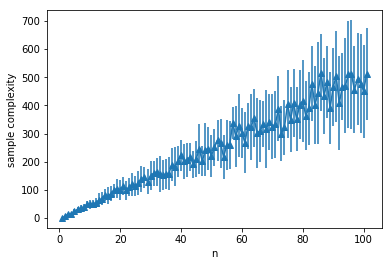

In [239]:
sample_complexity, iterations = estimate_sample_complexity(100,100,'perceptron')
plot_sample_complexity(sample_complexity)

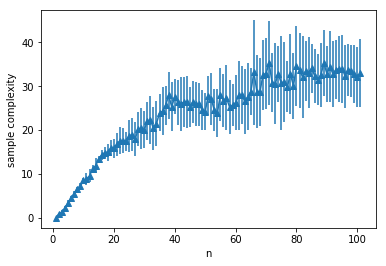

In [30]:
sample_complexity, iterations = estimate_sample_complexity(100,100,'winnow') #a bit slower, for some reason. 
plot_sample_complexity(sample_complexity)

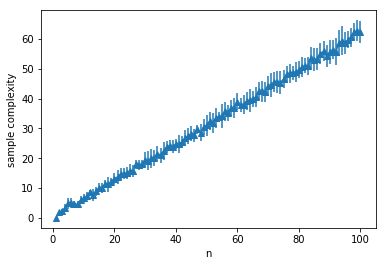

In [18]:
sample_complexity, iterations = estimate_sample_complexity(100,100,'linear') #a bit slower, for some reason. 
plot_sample_complexity(sample_complexity)

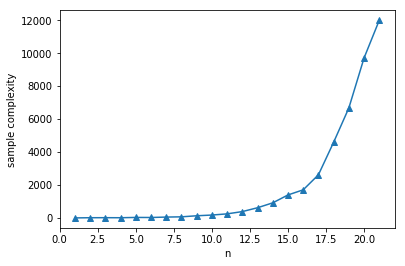

In [83]:
#sample_complexity, iterations = estimate_sample_complexity(10,20,'1nn',step_size=1,number_of_runs = 1)
#plot_sample_complexity(sample_complexity)

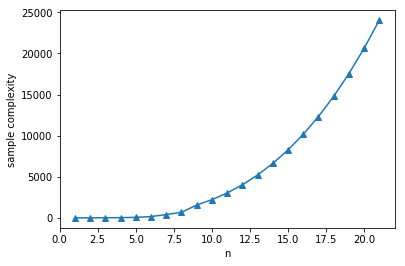

In [55]:
#sample complexity generated with new method. 
sample_complexity, iterations = estimate_sample_complexity_1nn(10,20,'1nn',step_size=1,number_of_runs = 1)
plot_sample_complexity(sample_complexity)

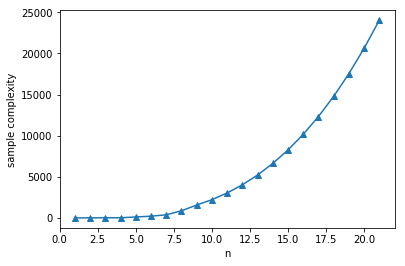

In [46]:
#sample complexity generated with old method. 
sample_complexity, iterations = estimate_sample_complexity_1nn(10,50,'1nn',step_size=50,number_of_runs = 1)
plot_sample_complexity(sample_complexity)

In [16]:
#sample_complexity3, iterations = estimate_sample_complexity_1nn(10,100,'1nn',step_size=40,number_of_runs = 1)
#plot_sample_complexity(sample_complexity3)

## Q1b)

## Discuss accuracy, computational time

### Procedure: 

Given a range of n, we estimate the sample complexity using Sampling and Binary Search algorithm. 

For each fixed n, we define the lower bound and upper bound of m values, depending on the algorithm.

Binary search is then applied onto the interval of m values, to find minimum m that satisfies $\epsilon_{test}(m)<0.1$. This step is repeated 20 times. 

$m_{left}$ is initialized to be the lower bound of m, $m_{right}$ is initialized to be the upper bound of m, and m_current is initialized to be n. 

Randomly sample training dataset of size($m_{left}$,n) and size($m_{right}$,n) from uniform distribution, train the chosen algorithm on these two training sets respectively, and test on a random test dataset of size(10000,n). 

Use the test error of each case as an estimator of generalization error. If $\epsilon_{test}(m_{left}) <\epsilon_{test}(m_{right})$, take the right half of this interval. Repeat the step till we find the minimum m such that $\epsilon_{test}(m)<0.1$. 



### Explaning the choice of training set size
The test set size = 10000 for all n in the test. But the total number of combinations of labels = $2^n$, meaning that the test set covers drastically less proportion of data points as n increases. The maximum proportion of input space represented by the test set   $\leq \frac{10000}{2^n}$, which is smaller than 1% when n=20. 

Similarly, the maximum proportion of input space represented by the training set $\leq \frac{m}{2^n}$, which is even smaller. 

### Explaining choosing the lower bound and upper bound of m


### Computational time of Sample Complexity Estimation
Suppose we want to estimate the sample complexity up to n_max, and repeat binary search for 20 runs, we will need to do the binary search procedure for $20 \times n_{max}$ times.  

Let the range of m considered in the binary search be M, $M = m_{left} - m_{right}$. M can be also treated as a function of n, since it is dependent on function choice. 

Fix n,m, and inside each run, the maximum number of times we apply the function calculate_test_error is $O(log_2(M))$.

Let the computational time of the chosen training algorithm to be $f(m,n)$, test algorithm to be $g(m,n)$. 

It takes the following steps to find sample complexity for fixed n,m:

Flops(n,m) = $O(log(M(n)) \times (g(m,n) + f(m,n))$

If m is bounded by M(n), then:

Flops(n,m) = Flops(n) = $O(log(M(n)) \times (g(M(n),n) + f(M(n),n))$ 

Overall, the total computational time of this sample complexity estimation for n up to a given $n_{max}$:

Flops($n_{max}$) =  num_runs $\times \sum_{n=1}^{n_{max}} Flops(n,M(n)) \sim O(Flops(n_{max},M(n_{max})))$

$\Rightarrow$ Flops($n_{max}$) $\sim  O(n_{max} log(M(n_{max})(g(M(n_{max}),n_{max}) + f(M(n_{max}),n_{max})))$



#### Perceptron
Now assuming if we ignore the error bound and only train algorithm for one epoch. 

$M(n) \sim  O(n)$

$f(m,n) \sim O(m,n) \sim O(n^2)$

$g(m,n) \sim O(10000n) $

Flops(n,m)  = $ O(log(n)) \times (O(mn) +  O(n))$ = $ O(mn$log$(n))$

Total computation steps for all m up to $n_{max}$:

Flops($n_{max})\sim  O(n_{max}$log$(n_{max})\times n_{max}^2) \sim O(n_{max}^3 $log$(n_{max}))$


#### Winnow
$g(m,n) \sim O(mn) $

$f(m,n) \sim O(10000n) \sim O(n)$

$M(n) \sim O(n)$

Flops(n,m)  = $ O(log(n)) \times (O(mn) +  O(n))$ = $ O(mn$log$(n))$

Total computation steps for all m up to $n_{max}$:

Flops($n_{max}) \sim O(n_{max}$log$(n_{max})\times n_{max}^2) \sim O(n_{max}^3 $log$(n_{max}))$


#### Linear Regression


#### 1-NN


In [ ]:
# Trade-off
# Use of interpolation instead of estimating for all m in [100]. 

In [ ]:
# Biases
# estimate the bias of our estimator? E(estimator) = gen_error, bias = 0 

## Q1 c) Estimate m(n)

### Perceptron

In [ ]:
from pylab import * 


### Winnow

### Linear Regression

### 1NN

log(m(n)) = 0.39 b+ 1.65
m(n)= 5.19 exp( 0.39 n)


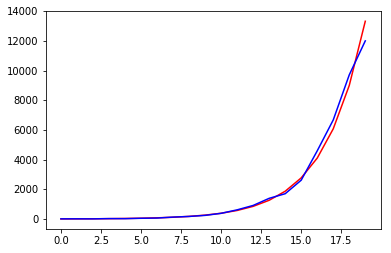

In [157]:
#Appears to be exponential
sample_complexity_1nn = sample_complexity2
log_sc = np.log(sample_complexity_1nn[1:].reshape(20))
m,b = polyfit(np.arange(1,21),log_sc,1)
fit = [b +m*x  for x in np.arange(1,21)]
print('log(m(n)) =',round(m,2),'b+',round(b,2) )
print('m(n)=',round(np.exp(b),2),'exp(',round(m,2),'n)')

plt.plot(np.exp(fit),color='r')
plt.plot(sample_complexity_1nn[1:],color='b')
plt.show()

In [ ]:
## Estimating Sample Complexity, by repeating 20 ru per each m and n

In [101]:
def estimate_sample_complexity_new(max_m,max_n,function_choice,step_size=1, number_of_runs=20):
    sample_complexity = np.zeros(max_n+1)
    iterations_per_n = np.zeros(max_n+1)
    gen_errors_arr= np.zeros((max_n+1))
    
    for n in np.arange(1,max_n+1,step_size):
        #research for a better test size, curse of dimensionality
        test_size = 10000
        #test_size = test_size if test_size > 0 and test_size < 10000 else 10000
        print("Now n=", n, "............", end='\r')
        print('n=',n)
        m_last = 0 
        #Repeat for number_of_runs runs. 
            
        m_left, m_right = bound_m(n,function_choice)
        print('range of m=',m_left,' and ', m_right)
             
        error_left = estimate_generalization_error(m_left,n,number_of_runs,function_choice,test_size)
        error_right = estimate_generalization_error(m_right,n,number_of_runs,function_choice,test_size)
        print('error_left=',error_left)
        print('error_right=',error_right)
        
        min_m_per_run = 1
        min_error_per_run = 1
        m_current = n
        iterations = 1
        #print('run=',run)
        found_m = False

        while found_m==False:
            m = int((m_left + m_right) / 2)
            gen_error = estimate_generalization_error(m,n,number_of_runs,function_choice,test_size)
            print("m_left: ", m_left, ", m_right: ", m_right, ", m: ", m, ", error: ", gen_error)
            
            if (m_right == m_left + 1):
                min_m_per_run = m_left if error_left <= error_right else m_right
                gen_error = error_left if error_left <= error_right else error_right

                if (gen_error<0.1):
                    found_m = True
                    break
                else:
                    m = m_last
                    #raise ValueError('gen error > 0.1 at converge point, m_left = m_right-1')
                    break

            # We check if it's smaller than 0.1. If it is then we're going to focus on (m_left, m) interval
            # Otherwise we will check (m, m_right)
            if gen_error < 0.1:
                m_last = m #store the latest m where this bound is achieved, gives more stability.
                if m < min_m_per_run:
#                        print("Kicking off ", min_m_per_run, " (", min_error_per_run,") in favour of ", m, "(",gen_error,")")
                    min_m_per_run = m
                    min_error_per_run = gen_error

                m_right = m  
                error_right = estimate_generalization_error(m_right,n,number_of_runs,function_choice,test_size)


            else:
                m_left = m  
                error_left = estimate_generalization_error(m_left,n,number_of_runs,function_choice,test_size)

            m_current = m

            if m_left == m_right:
                #print('finally narrowed down to one m!,m=',m)
                #print('gen_error=',error_right)
                found_m = True
                if (gen_error <0.1):
                    break
                else:
                    #print('bad error=',gen_error)
                    m = m_last
                    
                    print('min_m_per_run=',min_m_per_run)
                    #raise ValueError('gen error > 0.1 at converge point')
                    break
    
            iterations += 1
  
        gen_errors_arr[n] = gen_error #This is just to check if errors<0.1
        sample_complexity[n] = min_m_per_run
        iterations_per_n[n] += iterations
        print("Found m=", min_m_per_run, " for n=", n, " with ", iterations, " iterations")
        iterations_per_n[n] /= number_of_runs
        
    return sample_complexity, iterations_per_n,gen_errors_arr

In [81]:
def estimate_generalization_error(m,n,number_of_runs,function_choice,test_size):
    
    test_errors=np.zeros(number_of_runs)
    
    for run in range(number_of_runs):
        if function_choice == 'winnow':
            x_test,y_test = generate_data(test_size,n,winnow=True)
        else:
            x_test,y_test = generate_data(test_size,n)
            
        test_error = calculate_gen_error(m, n, x_test, y_test, function_choice)
        test_errors[run] = test_error          
    gen_error = test_errors.mean()   
    
    return gen_error


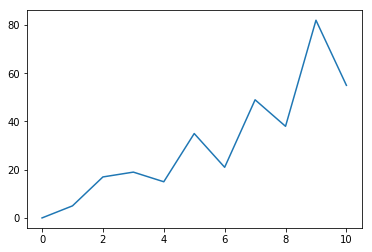

In [104]:
#sample_complexity, iterations,gen_error = estimate_sample_complexity_new(100,10,'perceptron',number_of_runs=20)
#plot_sample_complexity(sample_complexity)
plt.plot(sample_complexity)